In [1]:
import numpy as np
import pandas as pd
import os
from sklearn.preprocessing import MinMaxScaler
try:
    import tensorflow as tf
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, Flatten, Dense
    print("TensorFlow version:", tf.__version__)
except ImportError:
    print("⚐ TensorFlow is not installed. Please install it using 'pip install tensorflow' and restart the environment.")
    exit(1)
import joblib
import matplotlib.pyplot as plt


TensorFlow version: 2.18.0


In [3]:
# Step 1: Load All Cycles Using Metadata
def load_cycles(csv_folder, metadata_path):
    print(f"Loading metadata from {metadata_path}...")
    cycles = []
    try:
        if metadata_path.lower().endswith('.csv'):
            metadata_df = pd.read_csv(metadata_path)
        elif metadata_path.lower().endswith(('.xlsx', '.xls')):
            metadata_df = pd.read_excel(metadata_path)
        else:
            print(f"⚐ Unsupported metadata file format: {metadata_path}. Exiting.")
            return cycles
    except FileNotFoundError:
        print(f"⚐ Metadata file {metadata_path} not found. Exiting.")
        return cycles
    except Exception as e:
        print(f"⚐ Error reading metadata: {e}. Exiting.")
        return cycles

    print(f"Metadata contents:\n{metadata_df.head()}")
    if 'filename' not in metadata_df.columns or 'type' not in metadata_df.columns or 'battery_id' not in metadata_df.columns:
        print(f"⚐ Metadata file {metadata_path} lacks required columns (filename, type, battery_id). Available columns: {metadata_df.columns.tolist()}")
        return cycles

    b0005_metadata = metadata_df[metadata_df['battery_id'] == 'B0005']
    if b0005_metadata.empty:
        print(f"⚐ No entries found for battery_id B0005 in metadata. Exiting.")
        return cycles

    valid_files = set(b0005_metadata['filename'].values)
    print(f"Valid files for B0005: {valid_files}")

    all_files = os.listdir(csv_folder)
    b0005_files = [f for f in all_files if f in valid_files]
    print(f"Files found in {csv_folder} matching B0005 metadata: {b0005_files}")

    for file in b0005_files:
        file_path = os.path.join(csv_folder, file)
        try:
            df = pd.read_csv(file_path)
            column_map = {
                'time': ['time', 'Time', 'TIME', 't'],
                'current': ['current', 'Current_measured', 'CURRENT', 'Sense_current', 'Battery_current'],
                'voltage': ['voltage', 'Voltage_measured', 'VOLTAGE', 'v'],
                'impedance': ['Battery_impedance', 'Rectified_Impedance', 'Re']
            }
            time_col = next((col for col in column_map['time'] if col in df.columns), None)
            current_col = next((col for col in column_map['current'] if col in df.columns), None)
            voltage_col = next((col for col in column_map['voltage'] if col in df.columns), None)
            impedance_col = next((col for col in column_map['impedance'] if col in df.columns), None)

            file_type = b0005_metadata[b0005_metadata['filename'] == file]['type'].iloc[0]
            if not all([time_col, current_col, voltage_col]) and file_type in ['charge', 'discharge']:
                print(f"⚐ Error loading file {file}: Required columns (Time, Current, Voltage) not found. Available columns: {df.columns.tolist()}")
                continue
            df = df[[time_col, current_col, voltage_col]].rename(columns={
                time_col: 'Time',
                current_col: 'Current_measured',
                voltage_col: 'Voltage_measured'
            }) if file_type in ['charge', 'discharge'] else df
            cycle_index = b0005_metadata[b0005_metadata['filename'] == file]['cycle_index'].iloc[0] if 'cycle_index' in metadata_df.columns else 0
            if file_type == 'charge':
                cycles.append({
                    'filename': file,
                    'type': 'charge',
                    'data': df,
                    'capacity': 0.0,
                    're': 0.1,
                    'cycle_index': cycle_index
                })
            elif file_type == 'discharge':
                cycles.append({
                    'filename': file,
                    'type': 'discharge',
                    'data': df,
                    'capacity': 0.0,
                    're': 0.1,
                    'cycle_index': cycle_index
                })
            elif file_type == 'impedance':
                if not impedance_col:
                    print(f"⚐ Error loading file {file}: Required impedance column not found. Available columns: {df.columns.tolist()}")
                    continue
                if df[impedance_col].dtype == 'object':
                    def parse_complex(s):
                        try:
                            return complex(s).real if isinstance(s, str) else float(s)
                        except ValueError:
                            return np.nan
                    df[impedance_col] = df[impedance_col].apply(parse_complex)
                re = df[impedance_col].mean() if not df[impedance_col].isna().all() else 0.1
                r1 = re * 0.4
                r2 = re * 0.6
                c1 = 2000 / (re / r1) if re > 0 else 2000
                c2 = 5000 / (re / r2) if re > 0 else 5000
                cycles.append({
                    'filename': file,
                    'type': 'impedance',
                    'data': df,
                    'capacity': 0.0,
                    're': re,
                    'r1': r1,
                    'r2': r2,
                    'c1': c1,
                    'c2': c2,
                    'cycle_index': cycle_index
                })
            else:
                print(f"⚐ Unknown type {file_type} for file {file}. Skipping.")
        except Exception as e:
            print(f"⚐ Error loading file {file}: {e}")
    return cycles


In [5]:
# Step 2: Load and Preprocess Data for ML
def load_data_for_ml(cycles, sequence_length=64, max_rows=100000):
    X, y_soc = [], []
    scaler = MinMaxScaler()
    valid_cycle_count = 0
    total_rows = 0
    for cycle in cycles:
        df = cycle['data']
        print(f"Processing cycle {cycle['filename']} with length {len(df)}")
        if len(df) < sequence_length:
            print(f"⚐ Skipping cycle {cycle['filename']}: Insufficient data length ({len(df)} < {sequence_length})")
            continue
        valid_cycle_count += 1
        capacity = 2.0  # Default capacity
        time = df['Time'].values
        current = df['Current_measured'].values
        voltage = df['Voltage_measured'].values
        dt = np.diff(np.insert(time, 0, 0))
        charge = np.cumsum(current * dt)
        soc = charge / (capacity * 3600)
        soc = np.clip(soc, 0, 1)
        features = np.vstack((voltage, current, time)).T
        if total_rows + len(features) > max_rows:
            features = features[:max_rows - total_rows]
            soc = soc[:max_rows - total_rows]
        X.append(features)
        y_soc.append(soc)
        total_rows += len(features)
        if total_rows >= max_rows:
            break
    print(f"Number of valid cycles for ML: {valid_cycle_count}")
    if not X or not y_soc:
        print("⚐ No valid data for ML processing. Check cycle data.")
        return None, None, None, None
    X = np.vstack(X)
    y_soc = np.hstack(y_soc)
    X_scaled = scaler.fit_transform(X)
    joblib.dump(scaler, 'scaler_x.pkl')
    print(f"X_scaled shape: {X_scaled.shape}, y_soc shape: {y_soc.shape}")
    return X_scaled, y_soc, scaler, cycles


In [7]:
# Step 3: Prepare Sequences for CNN
def prepare_sequences(X, y, sequence_length=64):
    X_seq, y_seq = [], []
    for i in range(0, len(X) - sequence_length + 1):
        X_seq.append(X[i:i + sequence_length])
        y_seq.append(y[i + sequence_length - 1])
    return np.array(X_seq), np.array(y_seq)


In [9]:
# Step 4: Train CNN Model
def train_cnn(X, y, sequence_length=64):
    if X.shape[0] < sequence_length:
        print(f"⚐ Insufficient data for CNN training (length {X.shape[0]} < {sequence_length}). Exiting.")
        return None
    X_seq, y_seq = prepare_sequences(X, y, sequence_length)
    if X_seq.size == 0 or y_seq.size == 0:
        print("⚐ No sequences prepared for CNN training. Check data.")
        return None
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], X.shape[1]))
    print(f"Training CNN with X_seq shape: {X_seq.shape}, y_seq shape: {y_seq.shape}")
    inputs = Input(shape=(sequence_length, X.shape[1]))
    x = Conv1D(filters=32, kernel_size=3, activation='relu')(inputs)
    x = MaxPooling1D(pool_size=2)(x)
    x = Conv1D(filters=64, kernel_size=3, activation='relu')(x)
    x = MaxPooling1D(pool_size=2)(x)
    x = Flatten()(x)
    x = Dense(50, activation='relu')(x)
    outputs = Dense(1)(x)
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    print("Starting model fitting...")
    history = model.fit(X_seq, y_seq, epochs=5, batch_size=16, validation_split=0.2, verbose=1)
    for epoch, (train_loss, val_loss) in enumerate(zip(history.history['loss'], history.history['val_loss']), 1):
        print(f"Epoch {epoch}: Training Loss = {train_loss:.4f}, Validation Loss = {val_loss:.4f}")
    return model


In [11]:
# Step 5: ECM and UKF Implementation
def ecm_model(state, current, params, dt):
    soc, v1, v2 = state
    r0, r1, r2, c1, c2 = params['r0'], params['r1'], params['r2'], params['c1'], params['c2']
    ocv = 3.4 + 0.9 * soc - 0.1 * soc**2 + 0.05 * soc**3 if soc < 0.1 else 3.4 + 0.9 * soc - 0.1 * soc**2
    dsoc_dt = current / (params['capacity'] * 3600) if abs(current) > 0.01 else 0
    dv1_dt = -v1 / (r1 * c1) + current / c1
    dv2_dt = -v2 / (r2 * c2) + current / c2
    soc_next = soc + dsoc_dt * dt
    v1_next = v1 + dv1_dt * dt
    v2_next = v2 + dv2_dt * dt
    v_terminal = ocv - v1_next - v2_next - current * r0
    return np.array([soc_next, v1_next, v2_next]), v_terminal


In [13]:
def ukf_step(state, P, current, v_measured, params, dt, Q, R):
    n = len(state)  # State dimension (3: SOC, v1, v2)
    lambda_ = 3 - n  # Scaling parameter
    c = n + lambda_
    Wm = [lambda_ / c] + [1 / (2 * c)] * (2 * n)  # Mean weights (7 points)
    Wc = Wm.copy()  # Covariance weights
    Wc[0] = lambda_ / c + (1 - n**2)
    
    # Generate sigma points
    L = np.linalg.cholesky((n + lambda_) * P)
    sigma_points = [state]
    for i in range(n):
        sigma_points.append(state + L[i, :])  # Correct 1D state with 2D Cholesky
        sigma_points.append(state - L[i, :])
    sigma_points = np.array(sigma_points)
    print(f"Sigma points shape: {sigma_points.shape}")  # Debug: Should be (7, 3)
    
    # Propagate sigma points through the model
    sigma_states = []
    sigma_outputs = []
    for s in sigma_points:
        state_next, output = ecm_model(s, current, params, dt)
        sigma_states.append(state_next)
        sigma_outputs.append(output)
    sigma_states = np.array(sigma_states)
    sigma_outputs = np.array(sigma_outputs)
    print(f"Sigma states shape: {sigma_states.shape}, Sigma outputs shape: {sigma_outputs.shape}")  # Debug
    
    # Predicted state and covariance
    state_pred = np.sum([Wm[i] * sigma_states[i] for i in range(2 * n + 1)], axis=0)
    P_pred = np.sum([Wc[i] * np.outer(sigma_states[i] - state_pred, sigma_states[i] - state_pred) 
                    for i in range(2 * n + 1)], axis=0) + Q
    print(f"State pred shape: {state_pred.shape}, P_pred shape: {P_pred.shape}")  # Debug
    
    # Measurement update
    y_pred = np.sum([Wm[i] * sigma_outputs[i] for i in range(2 * n + 1)], axis=0)
    P_yy = np.sum([Wc[i] * np.outer(sigma_outputs[i] - y_pred, sigma_outputs[i] - y_pred) 
                  for i in range(2 * n + 1)], axis=0) + R
    P_xy = np.sum([Wc[i] * np.outer(sigma_states[i] - state_pred, sigma_outputs[i] - y_pred) 
                  for i in range(2 * n + 1)], axis=0)
    
    # Add small regularization to ensure invertibility
    P_yy = P_yy + np.eye(1) * 1e-6  # 1x1 matrix for scalar measurement
    K = P_xy @ np.linalg.inv(P_yy)  # K should be (3, 1)
    print(f"K shape: {K.shape}, P_yy shape: {P_yy.shape}")  # Debug
    innovation = (v_measured - y_pred).reshape(-1, 1)  # Ensure column vector (1, 1)
    state_updated = state_pred.reshape(-1, 1) + K @ innovation  # Ensure compatibility
    P_updated = P_pred - K @ P_yy @ K.T
    
    # Clamp SOC and flatten
    state_updated[0, 0] = np.clip(state_updated[0, 0], 0, 1)
    return state_updated.flatten(), P_updated


In [15]:
def plot_charge_soc(times_charge, soc_estimates_charge):
    if times_charge is not None and soc_estimates_charge is not None and len(soc_estimates_charge) > 0:
        plt.figure(figsize=(12, 6))
        plt.plot(times_charge[1:], soc_estimates_charge, label='Estimated SOC (Charge)', color='blue')
        plt.xlabel('Time (s)')
        plt.ylabel('SOC')
        plt.title('Estimated SOC During Charging (CNN-UKF)')
        plt.legend()
        plt.grid(True)
        plt.show()
        print("Estimated SOC for charging cycle displayed.")
    else:
        print("No valid SOC estimates available for plotting.")


Starting process with folder: D:\NASA_Battery_Dataset\cleaned_dataset\data and metadata: D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv
Loading metadata from D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv...
Metadata contents:
        type                                         start_time  \
0  discharge  [2010.       7.      21.      15.       0.    ...   
1  impedance  [2010.       7.      21.      16.      53.    ...   
2     charge  [2010.       7.      21.      17.      25.    ...   
3  impedance                    [2010    7   21   20   31    5]   
4  discharge  [2.0100e+03 7.0000e+00 2.1000e+01 2.1000e+01 2...   

   ambient_temperature battery_id  test_id  uid   filename  \
0                    4      B0047        0    1  00001.csv   
1                   24      B0047        1    2  00002.csv   
2                    4      B0047        2    3  00003.csv   
3                   24      B0047        3    4  00004.csv   
4                    4      B0047        4    5 

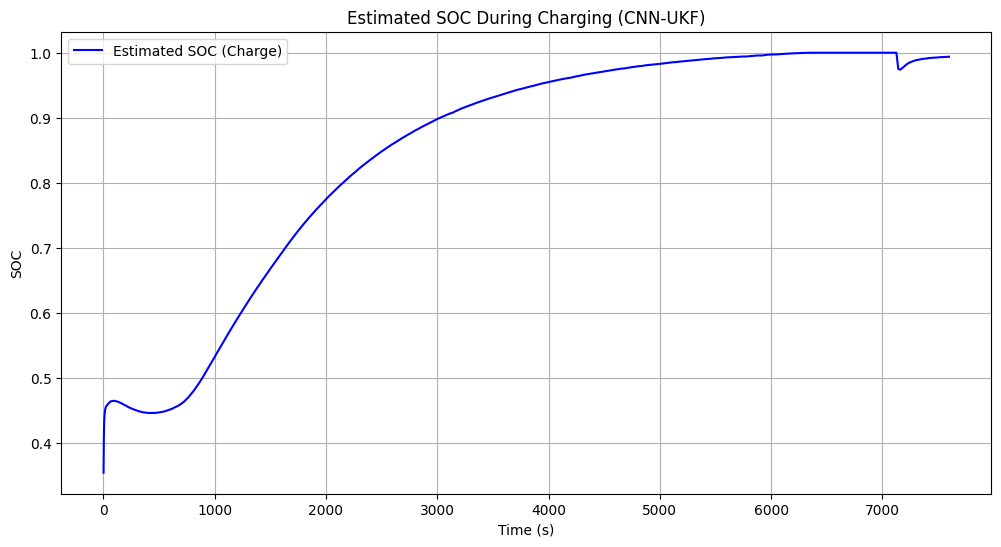

Estimated SOC for charging cycle displayed.


In [17]:
# [Previous code remains unchanged until main]

def main():
    csv_folder = r"D:\NASA_Battery_Dataset\cleaned_dataset\data"
    metadata_path = r"D:\NASA_Battery_Dataset\cleaned_dataset\metadata.csv"
    print(f"Starting process with folder: {csv_folder} and metadata: {metadata_path}")
    
    cycles = load_cycles(csv_folder, metadata_path)
    if not cycles:
        print("No cycles loaded. Check file paths, metadata columns, and file contents.")
        return
    
    X_scaled, y_soc, scaler, cycles = load_data_for_ml(cycles, max_rows=100000)
    if X_scaled is None or y_soc is None:
        print("ML data preparation failed. Exiting.")
        return
    
    print("Starting CNN training...")
    cnn_model = train_cnn(X_scaled, y_soc)
    if cnn_model is None:
        print("CNN training failed. Exiting.")
        return
    
    params = {'r0': 0.1, 'r1': 0.0688, 'r2': 0.1031, 'c1': 800, 'c2': 3000, 'capacity': 1.9}  # Adjusted r0
    state = np.array([0.1, 0.0, 0.0])  # Start with low SOC
    P = np.eye(3) * 0.1  # Increased initial covariance
    Q = np.eye(3) * 1e-2  # Process noise
    R = 0.05  # Measurement noise
    
    charge_cycles = [c for c in cycles if c['type'] == 'charge']
    if not charge_cycles:
        print("⚐ No charge cycles found. Exiting.")
        return
    
    # Process Charge Cycle
    charge_cycle = charge_cycles[0]
    df_charge = charge_cycle['data']
    voltages_charge = df_charge['Voltage_measured'].values
    currents_charge = df_charge['Current_measured'].values
    if currents_charge[0] <= 0:
        currents_charge = -currents_charge  # Assume charging current is positive
    print(f"First current value (charge): {currents_charge[0]:.2f}")
    times_charge = df_charge['Time'].values
    params['capacity'] = charge_cycle['capacity'] if charge_cycle['capacity'] > 0 else 1.9
    
    if len(voltages_charge) >= 64:
        features = np.vstack((voltages_charge[:64], currents_charge[:64], times_charge[:64])).T
        features_scaled = scaler.transform(features)
        features_seq = features_scaled[-64:].reshape(1, 64, 3)
        initial_soc = np.clip(cnn_model.predict(features_seq)[0][0], 0, 1)
        
        impedance_cycle = next((c for c in cycles if c['type'] == 'impedance' and c['cycle_index'] == charge_cycle['cycle_index']), None)
        if impedance_cycle:
            params['r1'] = impedance_cycle['r1']
            params['r2'] = impedance_cycle['r2']
            params['c1'] = impedance_cycle['c1']
            params['c2'] = impedance_cycle['c2']
            print(f"Using impedance-derived r1: {params['r1']:.4f}, r2: {params['r2']:.4f}, c1: {params['c1']:.0f}, c2: {params['c2']:.0f}")
        else:
            print(f"No impedance data for cycle {charge_cycle['cycle_index']}, using default values: r1={params['r1']}, r2={params['r2']}, c1={params['c1']}, c2={params['c2']}")
        
        dt0 = times_charge[1] - times_charge[0] if len(times_charge) > 1 else 1.0
        i0 = currents_charge[0]
        v0_measured = voltages_charge[0]
        tau1 = params['r1'] * params['c1']
        tau2 = params['r2'] * params['c2']
        v1_initial = i0 * params['r1'] * (1 - np.exp(-dt0 / tau1))
        v2_initial = i0 * params['r2'] * (1 - np.exp(-dt0 / tau2))
        ocv_initial = v0_measured + i0 * params['r0'] + v1_initial + v2_initial
        a = -0.1
        b = 0.9
        c = 3.4 - ocv_initial
        d = b**2 - 4*a*c
        if d >= 0:
            soc1 = (-b + np.sqrt(d)) / (2*a)
            soc2 = (-b - np.sqrt(d)) / (2*a)
            if 0 <= soc1 <= 1:
                soc_from_ocv = soc1
            elif 0 <= soc2 <= 1:
                soc_from_ocv = soc2
            else:
                soc_from_ocv = 0.5
        else:
            soc_from_ocv = 0.5
        initial_soc = (initial_soc + soc_from_ocv) / 2
        
        state = np.array([initial_soc, v1_initial, v2_initial])
        _, v_terminal_initial = ecm_model(state, i0, params, dt0)
        print(f"Initial SOC from CNN: {initial_soc:.2f}, v1: {v1_initial:.2f}, v2: {v2_initial:.2f}")
        print(f"Initial v_measured: {v0_measured:.2f}, v_terminal_pred: {v_terminal_initial:.2f}")
        if abs(v0_measured - v_terminal_initial) > 0.1:
            print(f"⚐ Warning: Initial v_terminal ({v_terminal_initial:.2f}) differs from v_measured ({v0_measured:.2f}) by more than 0.1V. Consider adjusting parameters.")
    
    soc_estimates_charge = []
    prev_current = currents_charge[0]
    for t in range(1, len(voltages_charge)):
        try:
            dt = times_charge[t] - times_charge[t-1]
            current = currents_charge[t]
            v_measured = voltages_charge[t]
            # Reset v1, v2 if current direction changes significantly
            if prev_current * current < 0 and abs(current) > 0.01:
                state[1] = current * params['r1'] * (1 - np.exp(-dt / tau1))
                state[2] = current * params['r2'] * (1 - np.exp(-dt / tau2))
            prev_current = current
            state, P = ukf_step(state, P, current, v_measured, params, dt, Q, R)
            soc_estimates_charge.append(state[0])
            residual = abs(v_measured - v_terminal_initial)  # Simplified residual (should use actual v_terminal from ecm_model)
            if residual > 0.1:
                print(f"Warning: High residual {residual:.2f}V at time {times_charge[t]:.2f}s")
            print(f"Time: {times_charge[t]:.2f}s, SOC: {state[0]:.2f}, Current: {current:.2f}, Residual: {residual:.2f}V")
        except Exception as e:
            print(f"Error at index {t} (charge): {e}")
            continue

    # Plot Results
    plot_charge_soc(times_charge, soc_estimates_charge)

if __name__ == "__main__":
    main()